In [1]:
from underworld import UWGeodynamics as GEO
from underworld import visualisation as vis

import underworld as uw
from underworld import function as fn
import numpy as np
import math

u = GEO.UnitRegistry
#GEO.__version__

loaded rc file /opt/venv/lib/python3.10/site-packages/underworld/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
velocity = 3.0 * u.centimetre / u.year

# Scaling
T0 = 293.15 * u.degK # 20 * u.degC
Tz = 1733.15 * u.degK # 1500 * u.degC

K_viscosity = 1e21  * u.pascal * u.second
K_density = 3300 * u.kilogram / (u.meter)**3
KH = 1000 * u.kilometer
K_gravity =  10. * u.meter / u.second**2

Kt = KH/velocity
bodyforce = K_density  * K_gravity 
KM = bodyforce * KH**2 * Kt**2
KT = Tz - T0

GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[length]"] = KH
GEO.scaling_coefficients["[mass]"] = KM
GEO.scaling_coefficients["[temperature]"] = KT
    
GEO.rcParams["swarm.particles.per.cell.2D"]= 20    

In [3]:
nx0 = 160
ny0 = 174 # 150+24

minCoord0 = (0. * u.kilometer, -660. * u.kilometer)
maxCoord0 = (1600 * u.kilometer,0. * u.kilometer )

minCoord1 = (0. * u.kilometer, -300. * u.kilometer)
maxCoord1 = (1600. * u.kilometer,0. * u.kilometer )


Model = GEO.Model(elementRes=(nx0,ny0),
                  minCoord=minCoord0,  
                  maxCoord=maxCoord1,
                  gravity=(0.0, -K_gravity))

Model.outputDir= "op_RefM1_uwg"
Model.minStrainRate = 1e-18 / u.second

	Global element size: 160x174
	Local offset of rank 0: 0x0
	Local range of rank 0: 160x174
In func WeightsCalculator_CalculateAll(): for swarm "DLVQ3FRG__swarm"
	done 33% (9280 cells)...
	done 67% (18560 cells)...
	done 100% (27840 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DLVQ3FRG__swarm"


In [4]:
topoy1 =  GEO.nd(0.5*u.kilometer) #fn.misc.constant([-
topoy2 =  GEO.nd(-2.5*u.kilometer)
topox1 =  GEO.nd(1200*u.kilometer)

meshz0 = GEO.nd(0.*u.kilometer)
meshz1 = GEO.nd(-300*u.kilometer)
meshz2 = GEO.nd(-660*u.kilometer)

dx = GEO.nd(1600*u.kilometer/nx0)
dy1 =  GEO.nd(2*u.kilometer)
dy2 = GEO.nd(15.*u.kilometer)

ny1 = int(np.round((meshz1-meshz2)/dy2))
ny2 = int(ny0-ny1) 

Model.fsmeshny = ny2
Model.fsmeshnx = nx0
Model.fsmeshny1 = ny1

Model.fsminCoord = tuple([GEO.nd(val) for val in minCoord1])
Model.fsmaxCoord = tuple([GEO.nd(val) for val in maxCoord1])

In [5]:
Model.mesh.reset()

#meshny1 = 

with Model.mesh.deform_mesh():
    for i in range(0,ny1+1):
            Model.mesh.data[((nx0+1)*i):((nx0+1)*(i+1)),1]= meshz2+dy2*i
    for i in range(ny1+1,ny0):
            Model.mesh.data[((nx0+1)*i):((nx0+1)*(i+1)),1]= meshz1+dy1*(i-ny1)

    conditionx1 = Model.mesh.data[Model.top_wall,0]<= topox1   
    conditionx2 = Model.mesh.data[Model.top_wall,0]> topox1 
    Model.mesh.data[Model.top_wall[np.where(conditionx1)],1] = topoy1
    Model.mesh.data[Model.top_wall[np.where(conditionx2)],1] = topoy2
#         Model.mesh.data[Model.top_wall,1] = topoy1
#     else: 
#         Model.mesh.data[Model.top_wall,1] = topoy2


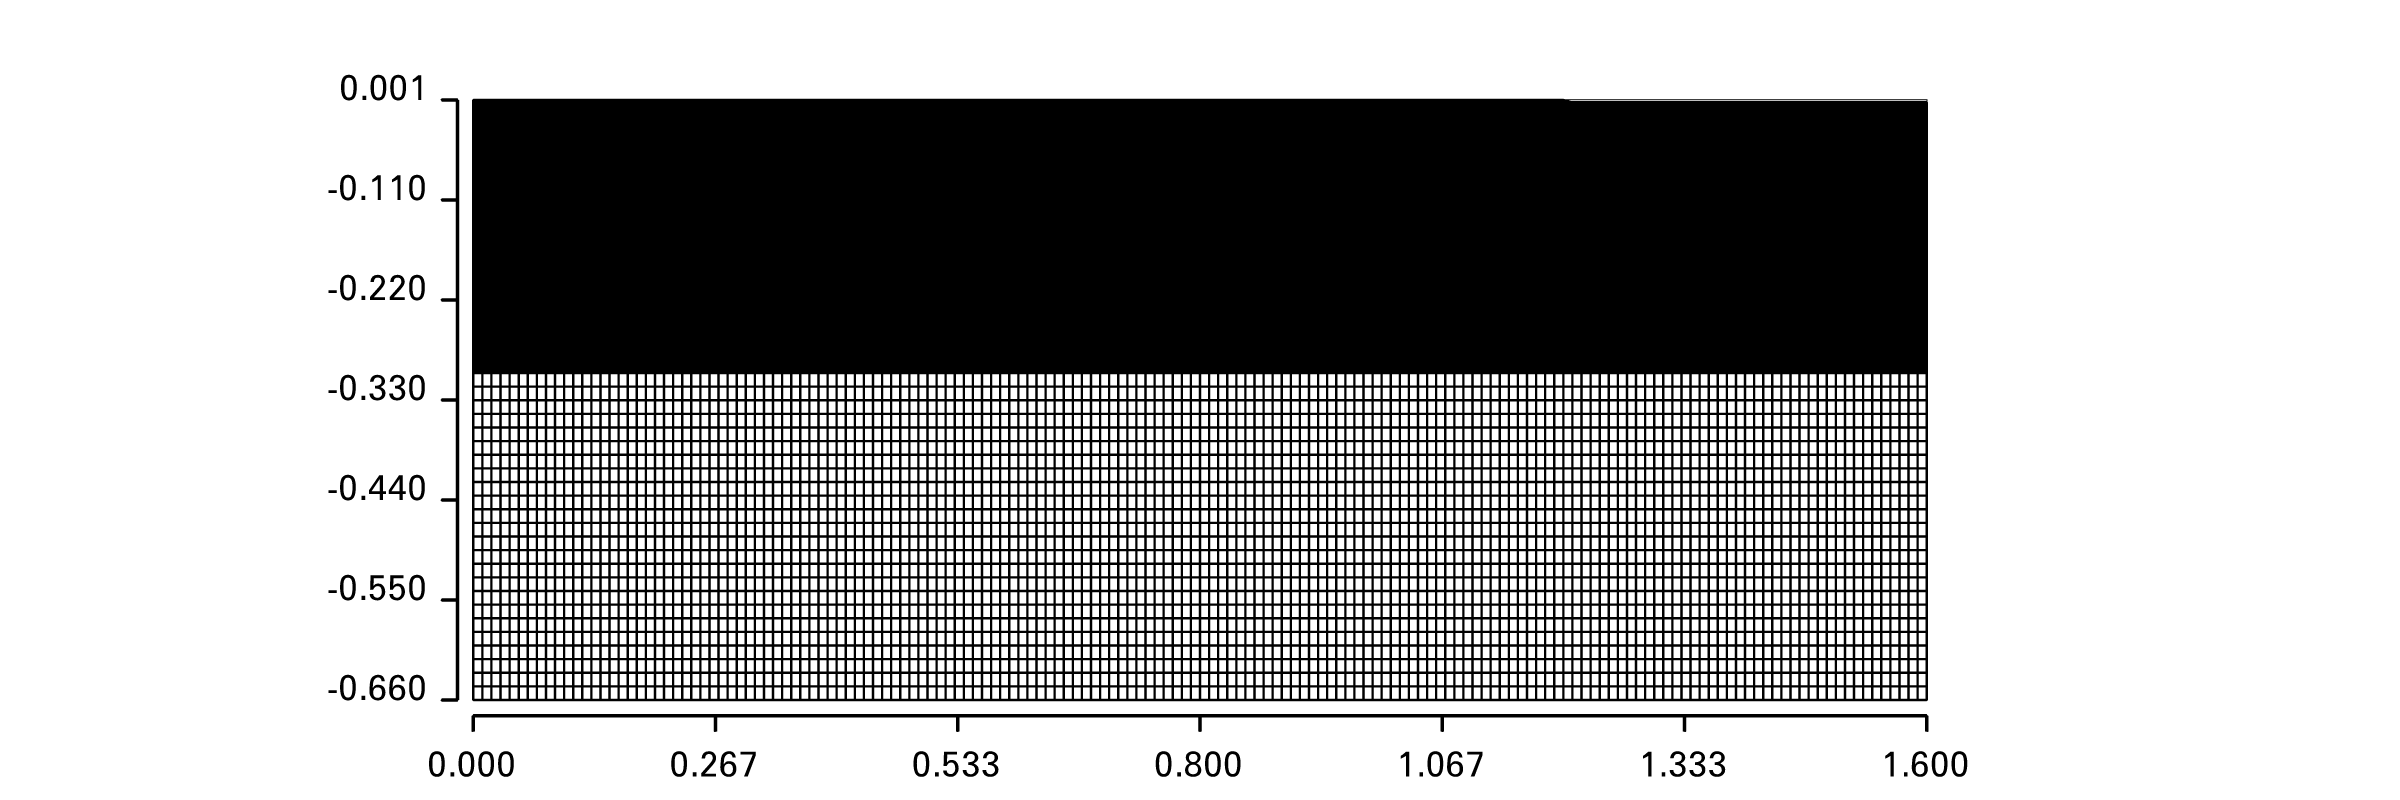

In [6]:
Fig = vis.Figure(resolution=(2400,800),rulers=True,margin = 100,rulerticks=7,quality=3,clipmap=False)
Fig.Mesh(Model.mesh, pointSize=4.0)
#Fig.Points(Model.swarm, Model.materialField,fn_size=4.0,discrete=True,colourBar=False)
Fig.show()
#Fig.save("mesh0.jpg")

In [7]:
def find_IndexSet(axis):
    Sets = Model.mesh.specialSets["Empty"]
    for index in axis:
        Sets.add(index)
    return Sets

In [8]:
# IndexSets for compensation depth
axis_cd = np.where((Model.mesh.data[:,1]<=meshz1+dy1/4)&(Model.mesh.data[:,1]>=meshz1-dy1/4))
Sets_cd = Model.mesh.specialSets["Empty"]
for index in axis_cd:
    Sets_cd.add(index)
    
meshz_check = GEO.nd(-150*u.kilometer)
axis_check = np.where((Model.mesh.data[:,1]<=meshz_check+dy1/4)&(Model.mesh.data[:,1]>=meshz_check-dy1/4))
Sets_check = Model.mesh.specialSets["Empty"]
for index in axis_check:
    Sets_check.add(index)    

In [9]:
minCoord = tuple([GEO.nd(val) for val in minCoord1])
maxCoord = tuple([GEO.nd(val) for val in maxCoord1])

mesh1 = uw.mesh.FeMesh_Cartesian(elementType=Model.elementType,
                                    elementRes=(nx0,ny2),
                                    minCoord=minCoord,
                                    maxCoord=maxCoord,
                                    periodic=Model.periodic)

TField = mesh1.add_variable(nodeDofCount=1)
TField.data[:, 0] = mesh1.data[:, 1].copy()

top = mesh1.specialSets['Top_VertexSet']
bottom = mesh1.specialSets['Bottom_VertexSet']
conditions = uw.conditions.DirichletCondition(variable=TField,indexSetsPerDof=(top + bottom,))
system = uw.systems.SteadyStateHeat(
    temperatureField=TField,
    fn_diffusivity=1.0,
    conditions=conditions)
solver = uw.systems.Solver(system)

TField.data[top, 0] = Model.mesh.data[Model.top_wall][:,1]

solver.solve()
with Model.mesh.deform_mesh():
     Model.mesh.data[(nx0+1)*(ny1):, -1] = TField.data[:, 0].copy()

	Global element size: 160x150
	Local offset of rank 0: 0x0
	Local range of rank 0: 160x150
Linear solver (SMNQKNJH__system-execute) 
Linear solver (SMNQKNJH__system-execute), solution time 5.024035e-02 (secs)


In [10]:
from underworld.swarm import Swarm
from collections import OrderedDict

Model.swarm_variables = OrderedDict()

Model.swarm = Swarm(mesh=Model.mesh, particleEscape=True)
Model.swarm.allow_parallel_nn = True
if Model.mesh.dim == 2:
    particlesPerCell = GEO.rcParams["swarm.particles.per.cell.2D"]
else:
    particlesPerCell = GEO.rcParams["swarm.particles.per.cell.3D"] 

Model._swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(
    swarm=Model.swarm,
    particlesPerCell=particlesPerCell)

Model.swarm.populate_using_layout(layout=Model._swarmLayout)

Model.population_control.repopulate()
Model.swarm.update_particle_owners()
        
Model._initialize()

In func WeightsCalculator_CalculateAll(): for swarm "DLVQ3FRG__swarm"
	done 33% (9280 cells)...
	done 67% (18560 cells)...
	done 100% (27840 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DLVQ3FRG__swarm"
In func WeightsCalculator_CalculateAll(): for swarm "6EGHFMF7__swarm"
	done 33% (9280 cells)...
	done 67% (18560 cells)...
	done 100% (27840 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "6EGHFMF7__swarm"



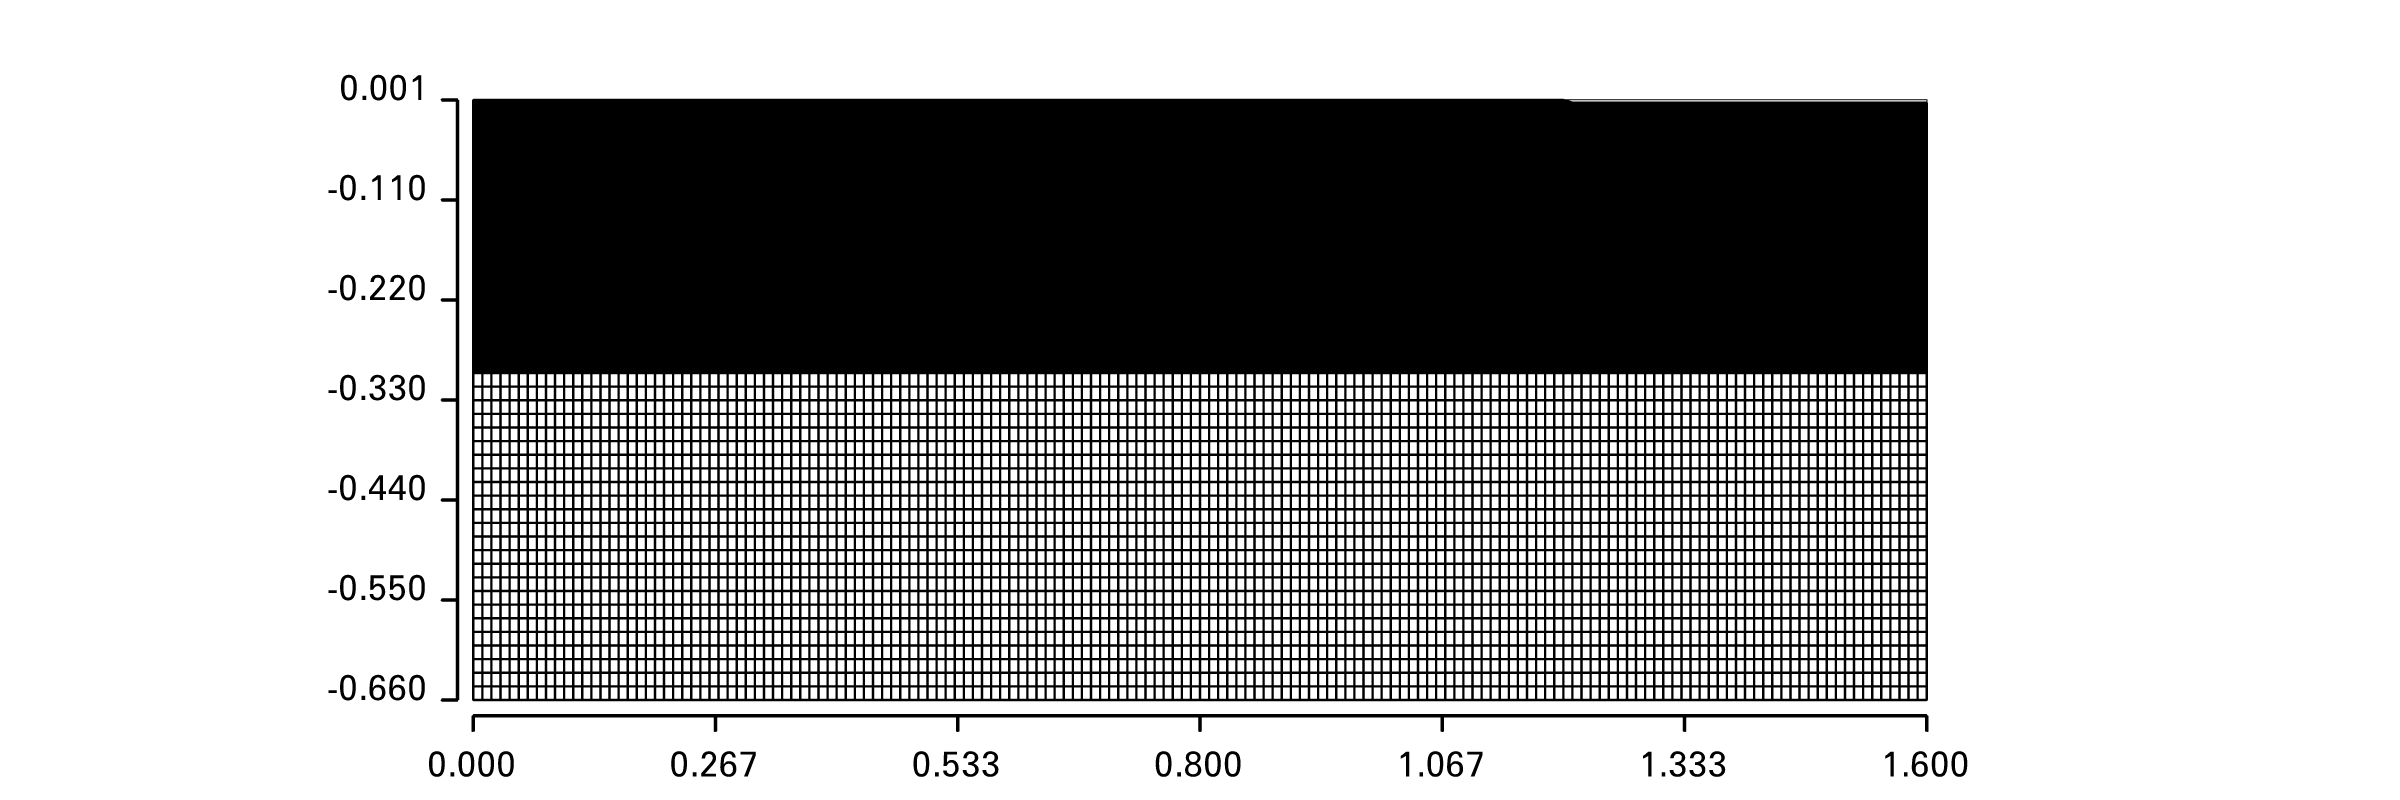

In [11]:
Fig = vis.Figure(resolution=(2400,800),rulers=True,margin = 100,rulerticks=7,quality=3,clipmap=False)
Fig.Mesh(Model.mesh, pointSize=4.0)
#Fig.Points(Model.swarm, Model.materialField,fn_size=4.0,discrete=True,colourBar=False)
Fig.show()
#Fig.save("mesh0.jpg")

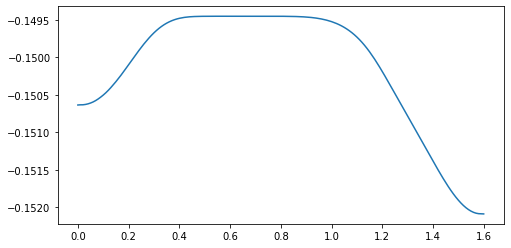

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots( 1, 1, figsize=(8,4) )
ax.plot(Model.mesh.data[Sets_check][:,0],Model.mesh.data[Sets_check][:,1])

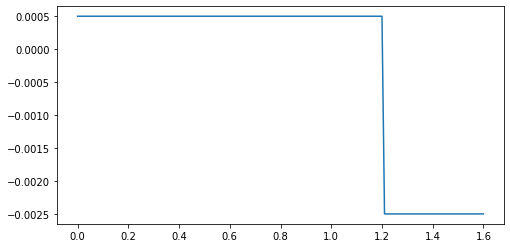

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots( 1, 1, figsize=(8,4) )
ax.plot(Model.mesh.data[Model.top_wall][:,0],Model.mesh.data[Model.top_wall][:,1])

In [14]:
Z_oc = -10. * u.kilometer
Z_ic = -35. * u.kilometer
Z_ac = -35. * u.kilometer

Z_oml = -80. * u.kilometer
Z_iml = -150. * u.kilometer
Z_aml = -150. * u.kilometer

Z_ma = -660. * u.kilometer

X0_oc = 1200. * u.kilometer
X1_oc = 1600. * u.kilometer
X0_ic = 800. * u.kilometer
X1_ic = 1200. * u.kilometer
X0_ac = 0. * u.kilometer
X1_ac = 800. * u.kilometer


h1 = 0.5*u.kilometer
h2 = -2.5*u.kilometer

oc_Shape = GEO.shapes.Polygon([(X0_oc,  h2),
                               (X1_oc,  h2),
                               (X1_oc, Z_oc),
                               (X0_oc, Z_oc)])

oml_Shape = GEO.shapes.Polygon([(X0_oc,  Z_oc),
                               (X1_oc,  Z_oc),
                               (X1_oc, Z_oml),
                               (X0_oc, Z_oml)])

ic_Shape = GEO.shapes.Polygon([(X0_ic,  h1),
                               (X1_ic,  h1),
                               (X1_ic, Z_ic),
                               (X0_ic, Z_ic)])

iml_Shape = GEO.shapes.Polygon([(X0_ic,  Z_ic),
                               (X1_ic,  Z_ic),
                               (X1_ic, Z_iml),
                               (X0_ic, Z_iml)])

ac_Shape = GEO.shapes.Polygon([(X0_ac,  h1),
                               (X1_ac,  h1),
                               (X1_ac, Z_ac),
                               (X0_ac, Z_ac)])

aml_Shape = GEO.shapes.Polygon([(X0_ac,  Z_ac),
                               (X1_ac,  Z_ac),
                               (X1_ac, Z_aml),
                               (X0_ac, Z_aml)])

ma_Shape = GEO.shapes.Polygon([(X0_ac,  Z_aml),
                    (X1_ic,  Z_iml),
                    (X0_oc,  Z_oml),
                    (X1_oc,  Z_oml),
                    (X1_oc, Z_ma),
                    (X0_ac, Z_ma)])
# GEO.shapes.Layer2D(top=0. * u.kilometer, bottom=-660. * u.kilometer)

In [15]:
ma   = Model.add_material(name="Mantle Asthenosphere", shape=ma_Shape)

oc   = Model.add_material(name="Oceanic Crust", shape=oc_Shape)
oml  = Model.add_material(name="Oceanic Mantle Lithosphere", shape=oml_Shape)

ac   = Model.add_material(name="Continental Crust", shape=ac_Shape)
aml  = Model.add_material(name="Continental Mantle Lithosphere", shape=aml_Shape)

ic    = Model.add_material(name="Indentor Crust", shape=ic_Shape)
iml  = Model.add_material(name="Indentor Mantle Lithosphere", shape=iml_Shape)

In [16]:
npoints = 250
coords0 = np.ndarray((npoints, 2))
coords0[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords0[:, 1] = GEO.nd(Z_ic)
coords0[:, 1][np.where(coords0[:, 0]>GEO.nd(X0_oc))] = GEO.nd(Z_oc)

coords1 = np.ndarray((npoints, 2))
coords1[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords1[:, 1] = GEO.nd(Z_iml)
coords1[:, 1][np.where(coords0[:, 0]>GEO.nd(X0_oc))] = GEO.nd(Z_oml)

Model.add_passive_tracers(name="Moho", vertices=coords0)
Model.add_passive_tracers(name="LAB", vertices=coords1)


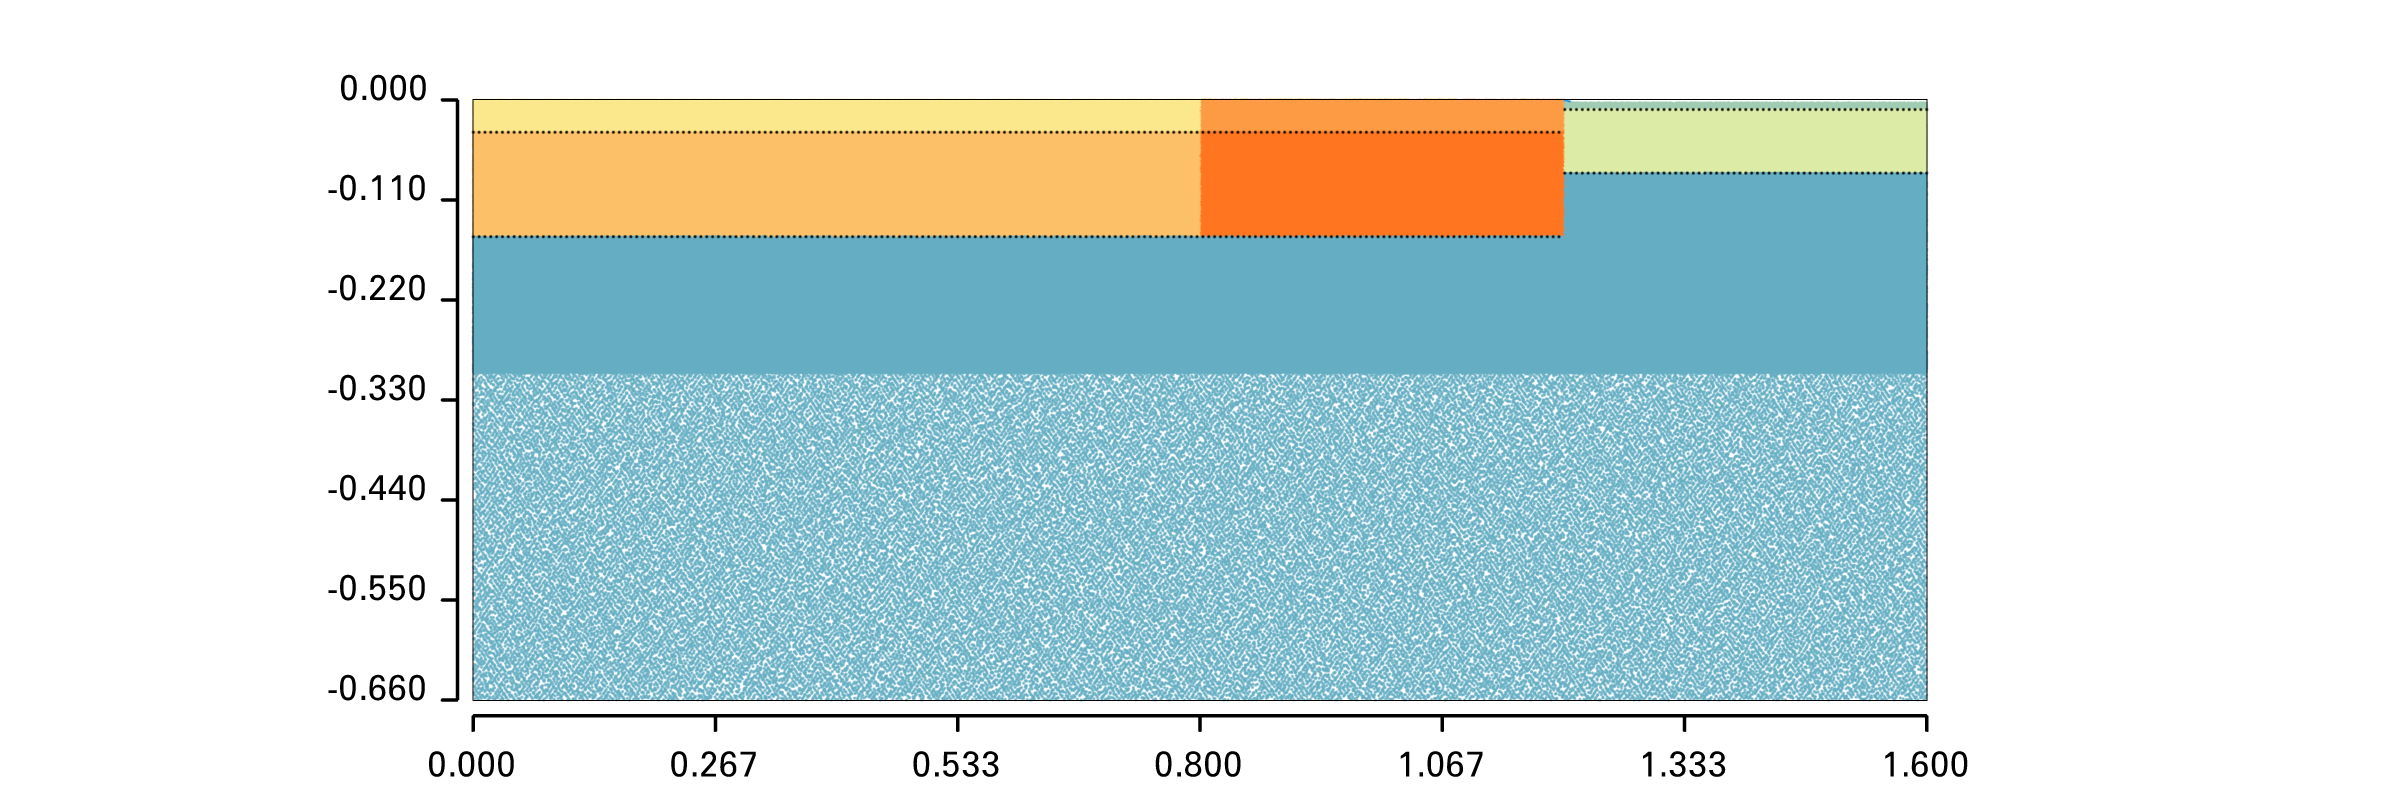

In [17]:
Fig = vis.Figure(resolution=(2400,800),rulers=True,margin = 100,rulerticks=7,quality=3,clipmap=False)
Fig.Points(Model.Moho_tracers, pointSize=4.0)
Fig.Points(Model.LAB_tracers, pointSize=4.0)
Fig.Points(Model.swarm, Model.materialField,fn_size=4.0,discrete=True,colourBar=False)
Fig.show()

In [18]:
dd = Model.materialField.data
coords11 = Model.swarm.data[np.where(dd==0)[0]]

Model.add_passive_tracers(name="bug", vertices=coords11)

In [19]:
GEO.dimensionalise(coords11,u.kilometer)

array([[  1.20189481e+03,  -1.25602314e+00],
       [  1.20689481e+03,  -1.61813336e+00],
       [  1.20220731e+03,  -1.12698341e+00],
       [  1.20470731e+03,  -2.28669340e+00],
       [  1.20345731e+03,  -2.24981568e+00],
       [  1.20095731e+03,   7.63236246e-02],
       [  1.20595731e+03,  -2.35039603e+00],
       [  1.20408231e+03,  -1.23259671e+00],
       [  1.20158231e+03,  -2.24479584e+00],
       [  1.20033231e+03,  -1.08172618e+00],
       [  1.20533231e+03,  -1.33653672e+00],
       [  1.20283231e+03,  -1.15548161e+00],
       [  1.20384793e+03,  -1.37896371e+00],
       [  1.20134793e+03,  -1.27838336e+00],
       [  1.20634793e+03,  -1.58684374e+00],
       [  1.20009793e+03,  -1.86998736e+00]]) <Unit('kilometer')>


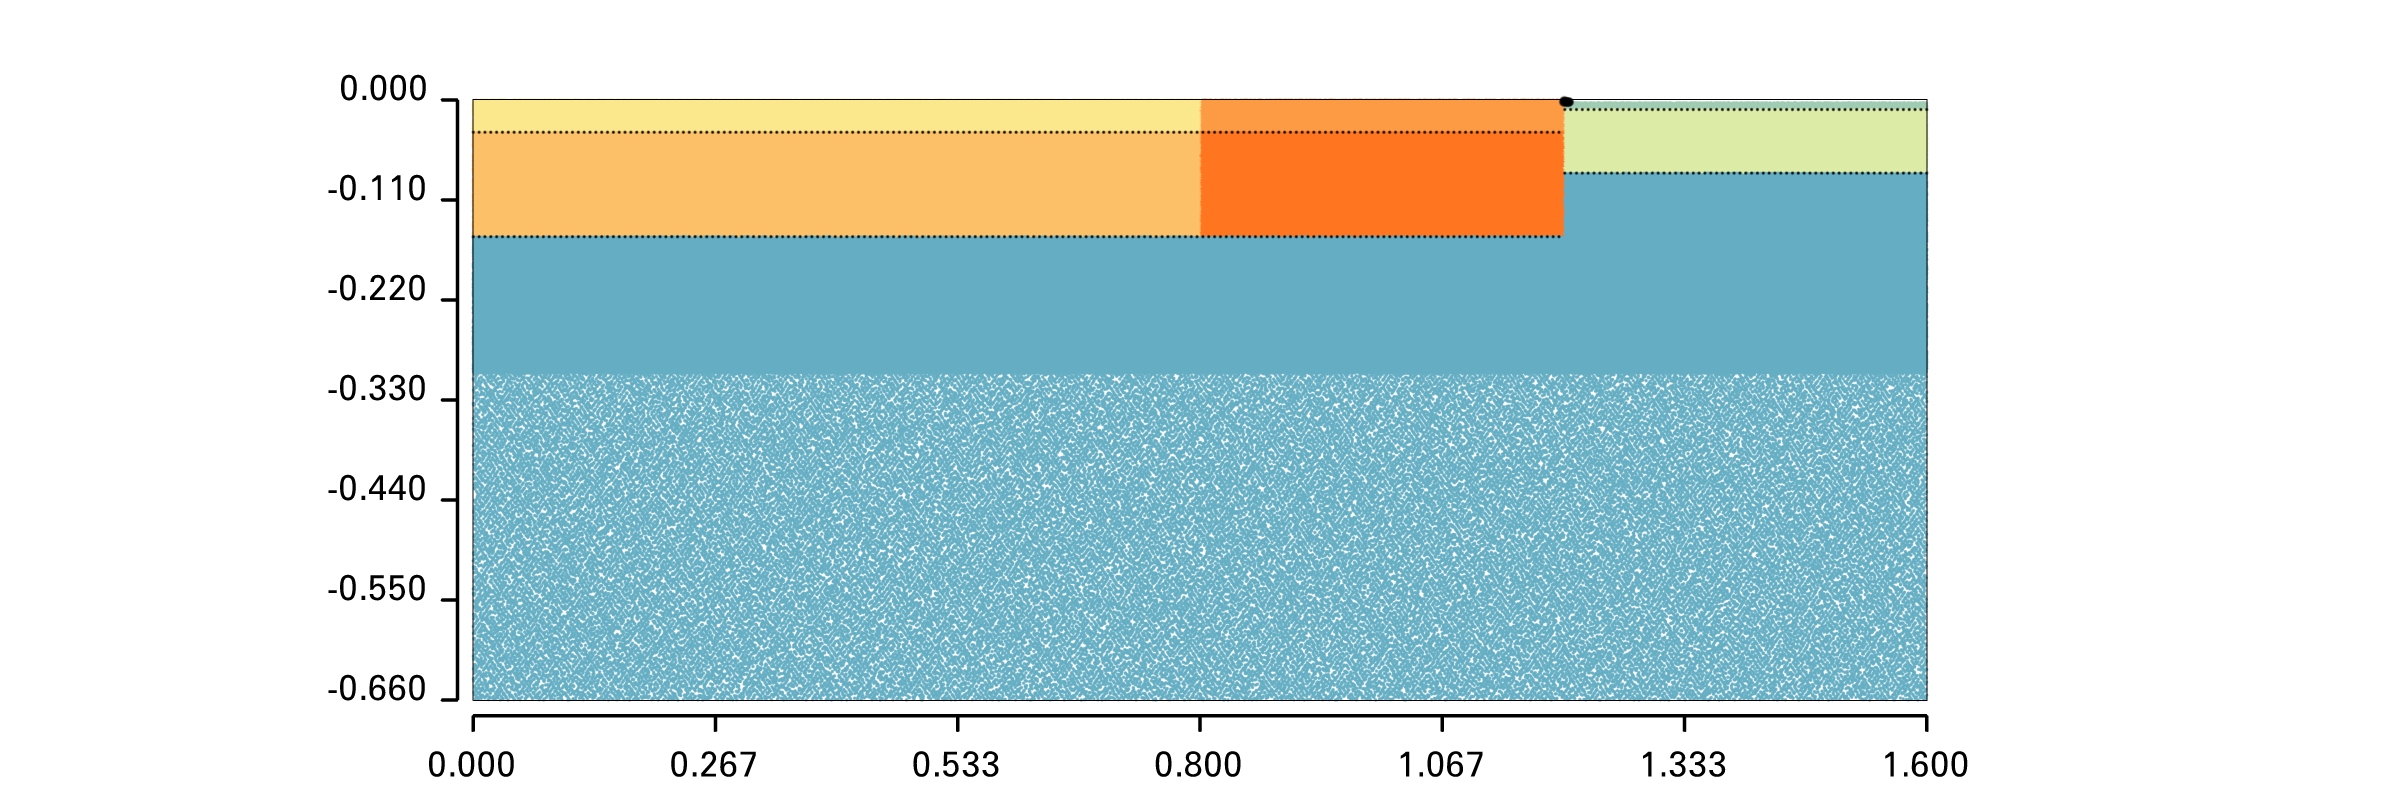

In [20]:
Fig = vis.Figure(resolution=(2400,800),rulers=True,margin = 100,rulerticks=7,quality=3,clipmap=False)
Fig.Points(Model.Moho_tracers, pointSize=4.0)
Fig.Points(Model.LAB_tracers, pointSize=4.0)
Fig.Points(Model.bug_tracers, pointSize=10.0)
Fig.Points(Model.swarm, Model.materialField,fn_size=4.0,discrete=True,colourBar=False)

Fig.Points(Model.swarm, Model.materialField,fn_size=4.0,discrete=True,colourBar=False)

Fig.show()

In [21]:
Model.materialField.data[np.where(Model.materialField.data==0)]=int(oc.index)

In [ ]:
ma.density = 3250 * u.kilogram / u.metre**3
#water.density = 1000 * u.kilogram / u.metre**3

oc.density = 2900 * u.kilogram / u.metre**3
oml.density = 3300 * u.kilogram / u.metre**3

ac.density = 2800 * u.kilogram / u.metre**3
aml.density = 3300 * u.kilogram / u.metre**3

ic.density = 2800 * u.kilogram / u.metre**3
iml.density = 3300 * u.kilogram / u.metre**3

In [ ]:
Model.minViscosity = 1e20 * u.pascal * u.second
Model.maxViscosity = 1e26 * u.pascal * u.second
ma.viscosity = 1e20 * u.pascal * u.second
oc.viscosity = 1e23 * u.pascal * u.second
oml.viscosity = 1e21 * u.pascal * u.second

ac.viscosity = 1e23 * u.pascal * u.second
aml.viscosity = 1e21 * u.pascal * u.second

ic.viscosity = 1e26 * u.pascal * u.second
iml.viscosity = 1e21 * u.pascal * u.second

In [ ]:
# Fig = vis.Figure(resolution=(2400,800),rulers=True,margin = 100,rulerticks=7,quality=3,clipmap=False)
# Fig.Points(Model.swarm,GEO.Model.densityField,fn_size=3.0)
# Fig.show()

In [ ]:
# Fig = vis.Figure(resolution=(2400,800),rulers=True,margin = 100,rulerticks=7,quality=3,clipmap=False)
# Fig.Points(Model.swarm,GEO.dimensionalise(Model.viscosityField, u.pascal * u.second),
#            logScale=True,
#            fn_size=3.0)
# Fig.show()

In [ ]:
axis_ic = np.where((Model.mesh.data[:,0]<=GEO.nd(X1_ic)+dx/4)&(Model.mesh.data[:,0]>=GEO.nd(X0_ic)-dx/4)&(Model.mesh.data[:,1]>=Z_ic))
IndexSet_ic = find_IndexSet(axis_ic)

In [ ]:
Model.set_velocityBCs(left=[0., None], right=[0., None], top=[None, None], bottom=[0.,0.],nodeSets=[(IndexSet_ic,[-velocity,0.])])

In [ ]:
Model.init_model(pressure="lithostatic")

In [ ]:
from _freesurface_NUMesh import FreeSurfaceProcessor
Model.freeSurface = True
Model._freeSurface = FreeSurfaceProcessor(Model)

In [ ]:
checkpoint_interval = 1e2*u.kiloyear
dt = 2.5*u.kiloyear
Model.run_for(2.0 * u.megayears, checkpoint_interval=checkpoint_interval,dt= dt)

In [ ]:
# import h5py   
# import matplotlib.pyplot as plt
# import numpy as np
# import math

# def load_surf_swarm(fdir,step):
#     fname = fdir+"interface-"+str(step)+".h5"
#     fh5   = h5py.File(fname ,'r')  
#     fdata = fh5["data"][()]
#     xcoord = fdata[:,0]
#     ycoord = fdata[:,1]
#     return xcoord,ycoord

# def load_depth(fdir,maxstep,dstep):
#     depth_l = []
#     depth_r = []
#     for step in range(0,maxstep+1,dstep):
#         xcoord,ycoord = load_surf_swarm(fdir,step)
#         depth_l.append(ycoord[0])   
#         depth_r.append(ycoord[-1])  
#     return np.array(depth_l),np.array(depth_r)